## The goal of this machine learning model is to predict the probability that the first transcation of a new user is fraudulent.

Below is the walk-through of my Machine Learning model development life cycle journey.

Note: I have links to all of my refernce articles below.

#### As a first step, I want to make sure all of my libraries are installed correctly

In [1]:
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn

print("libraries installed correctly, check the versions below;")
print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('sklearn: {}'.format(sklearn.__version__))

libraries installed correctly, check the versions below;
Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
scipy: 1.2.1
numpy: 1.16.2
matplotlib: 3.0.3
pandas: 0.24.2
sklearn: 0.20.3


#### I will import all the necessary packages (pretty much standard) list of packages and as I realise the need of more packages, this section is where I will be importing my packages.

In [2]:
import numpy
import pandas
from pandas.plotting import scatter_matrix 
import matplotlib.pyplot as plt #I need this package for my data visualization
import seaborn as sns #I need this package for my data visualization
from sklearn import model_selection #I need this package for implementing the models/algorithm
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression #I need this package for implementing the models/algorithm
from sklearn.neighbors import KNeighborsClassifier #I need this package for implementing the models/algorithm
from sklearn.naive_bayes import GaussianNB #I need this package for implementing the models/algorithm
from sklearn.svm import SVC #I need this package for implementing the models/algorithm
from sklearn.model_selection import train_test_split #I need this package for spliting my data into train and test sets

## STEP: DATA LOADING AND DATA EXPLORATION

#### The dataset that I will be using for this project is "transaction_data" which has the following columns;
user_id, signup_time, purchase_time, purchase_value, device_id, source, browser, sex, age, ip_address, class, country_ip_mapped
Note: I have implemented the IP address to country mapped which resulted in the column "country_ip_mapped" using Vlookup. 

I will be using this dataset through out my process for achieving the desired results

In [3]:
transaction_data = pandas.read_csv(r"Datasets/transaction_data.csv")

In [4]:
transaction_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_ip_mapped
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Poland
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,China


In [5]:
transaction_data.dtypes 
#shows all the data types of our columns. We will need this information in our pre-processing data step.

user_id                int64
signup_time           object
purchase_time         object
purchase_value         int64
device_id             object
source                object
browser               object
sex                   object
age                    int64
ip_address           float64
class                  int64
country_ip_mapped     object
dtype: object

In [6]:
transaction_data['class'].value_counts()  
#checking from the given data, how many of the transactions are fraudulent and we see that almost 9-10% of the  
#transcations are fradulent.

0    108735
1     11265
Name: class, dtype: int64

#### I will do some data visulization to know how the is the dependency of the features on our class of 0 or 1

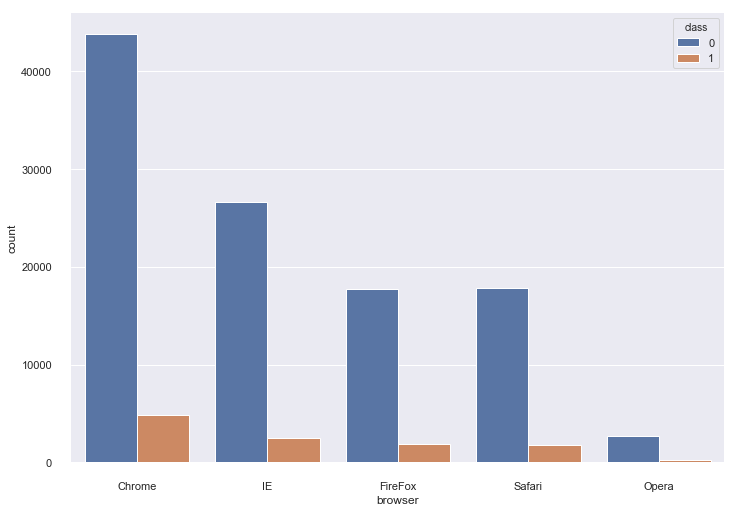

In [7]:
sns.set(style="whitegrid", color_codes=True)  #setting the backgroud color of my plots
sns.set(rc={'figure.figsize':(11.7,8.27)})  #I'm setting a size for my plots to be displayed
sns.countplot('browser',data=transaction_data,hue = 'class')
sns.despine(offset=10, trim=True)

#### In this case, we can notice that majority of our transactions are happening through the Chrome browser and we can relate that number of the fradulent cases are higher in number for transactions happening through Chrome. Therefore, we will have to consider this feature as part of the feature selection for building our ML model.


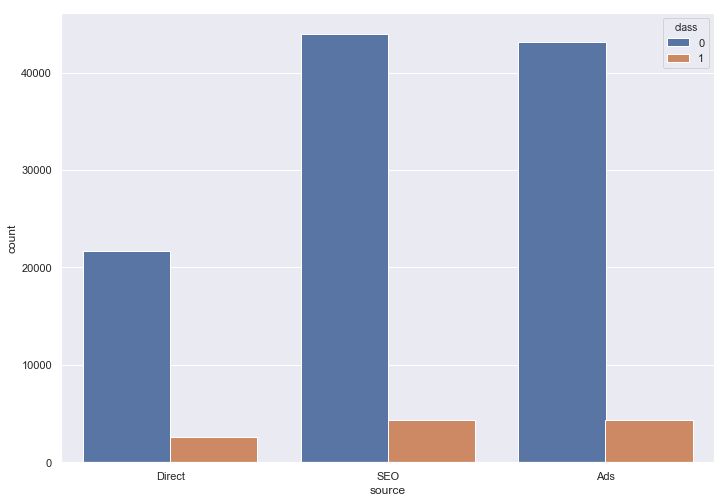

In [8]:
sns.countplot('source',data=transaction_data,hue = 'class')

#### From the above plot, we can notice that the fraudulency is lower for the DIRECT transactions compared to via SEOs or Ads. Hence, we will have to consider this feature as part of our feature selection for building our ML model.

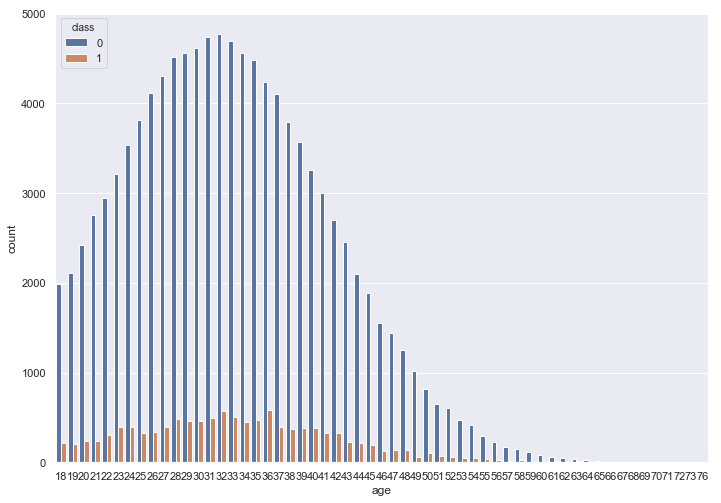

In [9]:
sns.countplot(x='age',data=transaction_data,hue='class')
plt.show()

#### This plot is just to visually compare the number of fradulent transactions versus the legitimate ones wih respect to the age. In this case, we can notice that the transactions in whole are inversely proportionate to the age factor.

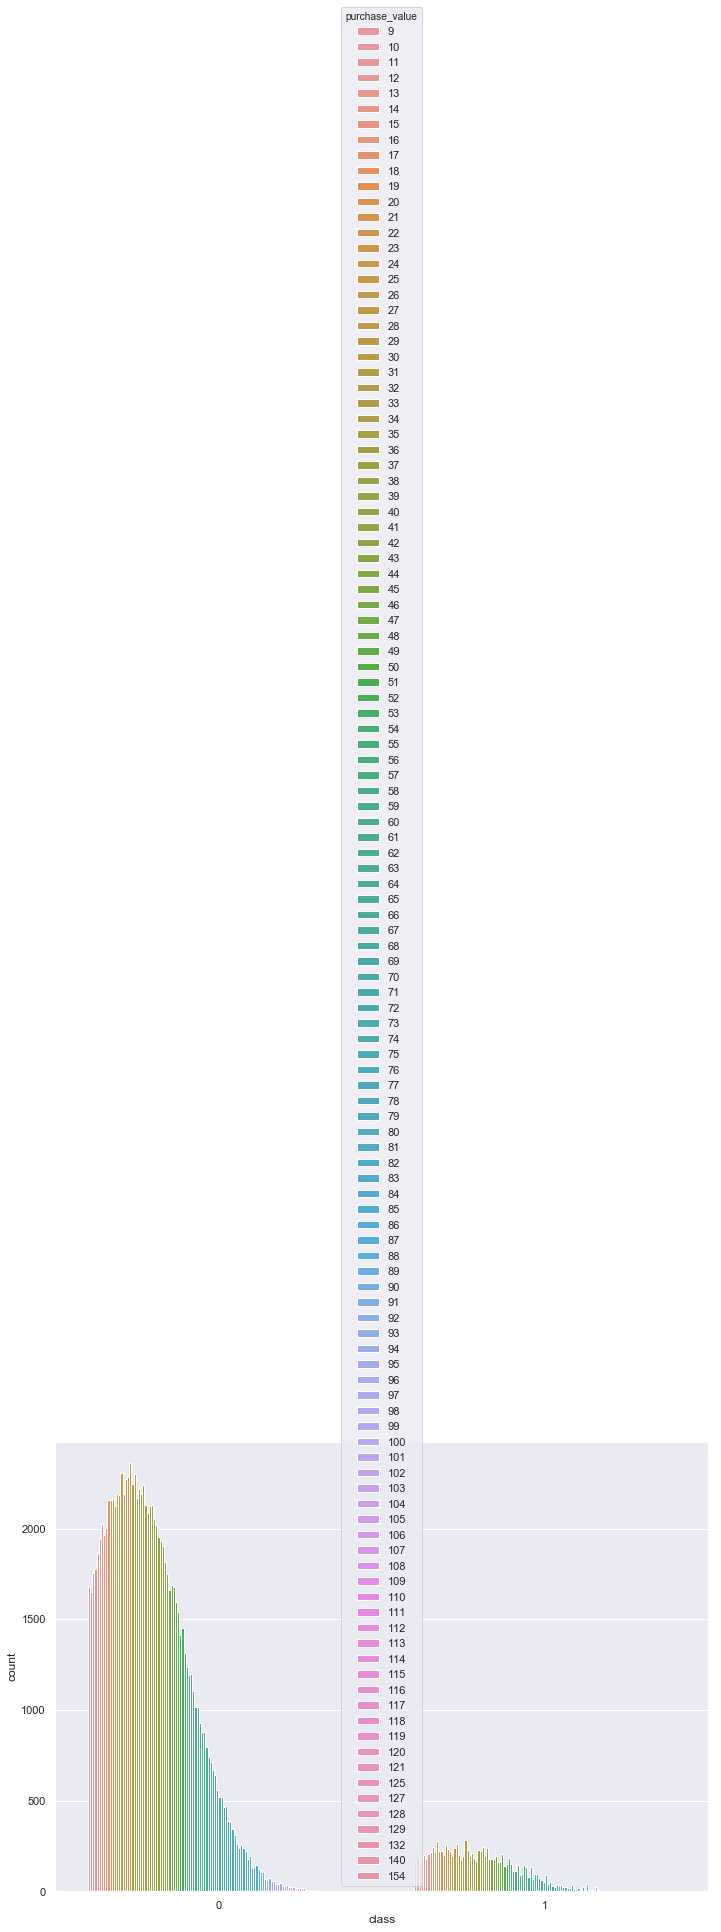

In [10]:
sns.countplot('class',data=transaction_data,hue = 'purchase_value')

#### I tried the above plot to find any sort of relation/impact of purchase value with our fradulent transactions, but its not much of an effective plot. But,I'm still keeping it here.

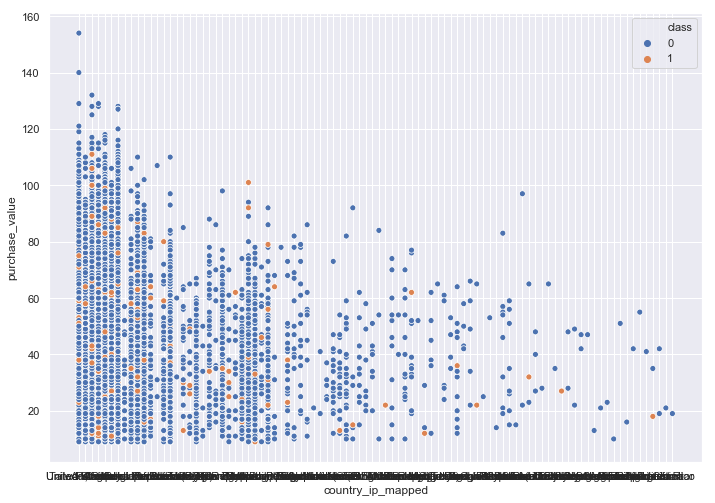

In [11]:
sns.scatterplot(y='purchase_value',x='country_ip_mapped',data=transaction_data,hue = 'class')

#### In my previous plot, I tried finding a relationship between the purchase value and the fraud transactions and since I could not find much of an answer, I'm rying to find some kind of pattern between the purchase values and the fraud transactions with respect to countries and I notice that there are some countries only that are performing many transactions and obviously the frequency of the fradulency is high with these countries. From this observation, I want to add  "country_ip_mapped" column as well into the list of our features which will be used for our model development. 
Note: I dont see much of a relationship of fradulency with purchase values. The fradulency is happening for pretty much all kinds of amount.Therefore, I might consider this feature as nothing but a noise to our model.

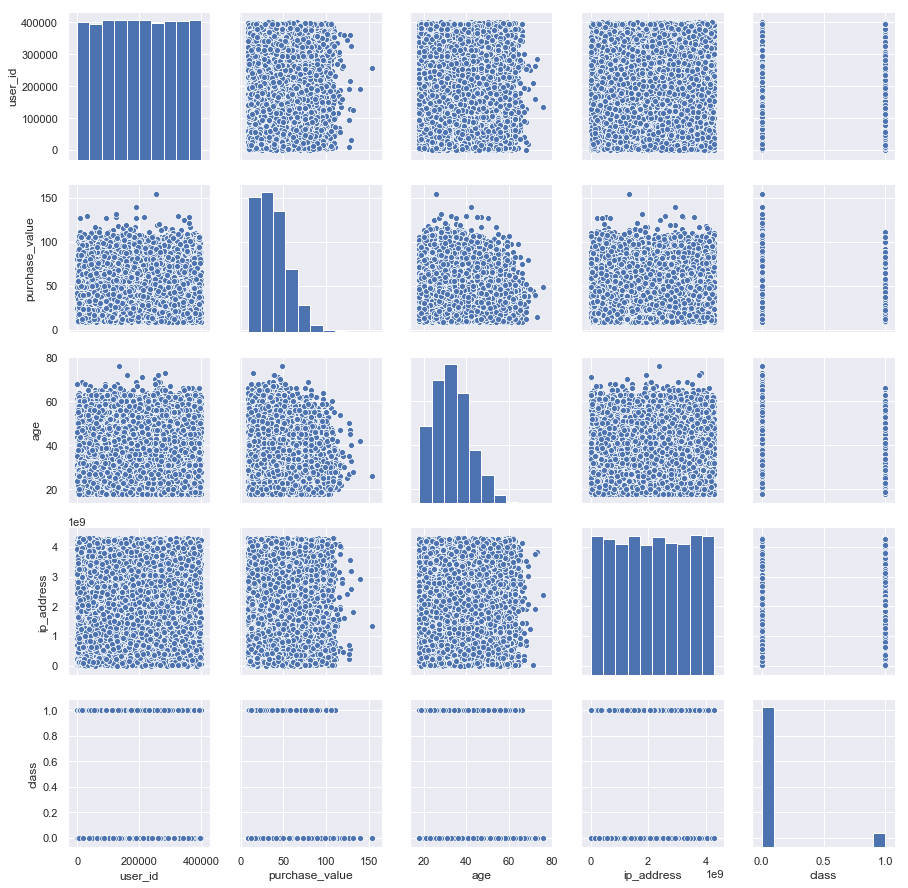

In [12]:
sns.pairplot(transaction_data)

#### Now that I have explored my data and have some idea on feeding this information to my model. I will go ahead and perform pre processing of my data and make it model feeding ready

## STEP: PRE PROCESSING DATA

#### I'm performing this step because I will be building a model using sci-kit learn algoithms. The algorithms in the sci-kit learn are defined in such a way that they understand only the numeric data. However, in my data exploration step, I noticed that most of my columns are the non-integer data types and therefore, I want to convert all of those columns into numerical labels. I will use the label encoder method which is part of preprocessing module of the Sci-kit learn. please refer to the below steps.

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()  # creating the Labelencoder object

In [14]:
print("device_id' : ",transaction_data['device_id'].unique())
print("sex' : ",transaction_data['sex'].unique())

device_id' :  ['HZAKVUFTDOSFD' 'XGQAJSOUJIZCC' 'VCCTAYDCWKZIY' ... 'EMMTCPTUYQYPX'
 'YSZGGEARGETEU' 'BJDWRJULJZNOV']
sex' :  ['M' 'F']


#### I checked unique values for some columns for my understanding. Now that I have created my LableEncoder Object, I will go ahead and convert all of my non-numrical types of labels into numerical labels. 

In [15]:
transaction_data['device_id'] = le.fit_transform(transaction_data['device_id'])
transaction_data['source'] = le.fit_transform(transaction_data['source'])
transaction_data['browser'] = le.fit_transform(transaction_data['browser'])
transaction_data['sex'] = le.fit_transform(transaction_data['sex'])
transaction_data['signup_time'] = le.fit_transform(transaction_data['signup_time'])
transaction_data['purchase_time'] = le.fit_transform(transaction_data['purchase_time'])
transaction_data['ip_address'] = le.fit_transform(transaction_data['ip_address'])
transaction_data['country_ip_mapped'] = le.fit_transform(transaction_data['country_ip_mapped'])


transaction_data.head()
# Displaying the initial 5 records for reference

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_ip_mapped
0,285108,89442,90499,31,33604,1,0,1,49,74549,0,90
1,131009,7748,29071,31,99057,2,2,0,21,85787,0,89
2,328855,29152,36959,16,89775,1,2,1,26,71993,0,90
3,229053,13461,2684,29,51591,2,0,1,34,55051,0,68
4,108439,27475,38414,26,95756,0,1,1,33,84569,0,16


#### Now our data is numeric and ready to be fed to our ML algorithms. 

## STEP: CREATING A VALIDATION DATASET: SPLITING MY DATA INTO TRAIN AND TEST DATA

#### I want to divide my data into 80% of training data and 20% of test data. As a traditional norm, I will build my model by training it with my training data (80% of my data) and test it with my test data (20% of my data)

#### I will be using NumPy array slicing for implementing my feature selection into my training and testing data. 

In [16]:
array = transaction_data.values
X = array[:,5:12]   
#I'm using my columns source, browser, sex, age, ip_address, class and country_ip_mapped as my feature selection.
#There is still noise but we can work on it as part of tuning the model for better accuracy
print (X)
print (X.shape)
print ("--------------------------------")
Y = array[:,10]  #My class in this class is "Class" at the index level 10 and this will be my Y data
print (Y)
print (Y.shape)

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=0.20, random_state=10)
#calling my train_test_split method for spliting my data into 80% train data and 20% train data.


[[    1     0     1 ... 74549     0    90]
 [    2     2     0 ... 85787     0    89]
 [    1     2     1 ... 71993     0    90]
 ...
 [    2     0     1 ... 15363     0     0]
 [    2     0     0 ... 70988     0    90]
 [    0     0     0 ... 31114     0     0]]
(120000, 7)
--------------------------------
[0 0 0 ... 0 0 0]
(120000,)


In [17]:
print (X_train.shape)
print (X_validation.shape)

print (Y_train.shape)
print (Y_validation.shape)

(96000, 7)
(24000, 7)
(96000,)
(24000,)


## STEP: CHOOSING RIGHT MODEL

We have a few straight forward points to note down;
1. Our data is structured
2. The ML model that we will be building is categorised as supervised learning because we are training the macine
3. The label we are condsidering as a class is binary with the values 0 or 1 response, 0 being fraulent transaction and 1 being non-fradulent transaction. Therefore this is a classification problem, hence I will choose one of the main classification algorithms;
       
        K Nearest Neighbours Algorithm
        Naive-Bayes Algorithm
        Logistic Regression


Additionally
As per the documentation of sci-kit Learn, there is a flowchart which tells us how to preceed with selecting a model based on our data. 
Attached is the link;

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


In [18]:
gnb = GaussianNB()
pred = gnb.fit(X_train, Y_train).predict(X_validation)
#training the model and testing it on my validation data(test data)
print("Naive-Bayes accuracy : ",accuracy_score(Y_validation, pred, normalize = True))

Naive-Bayes accuracy :  0.9067916666666667


In [19]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, Y_train)
pred = neigh.predict(X_validation)
print ("KNeighbors accuracy score : ",accuracy_score(Y_validation, pred))

KNeighbors accuracy score :  0.9388333333333333


In [20]:
LR = LogisticRegression(random_state=0)
LR.fit(X_train,Y_train)
pred = LR.predict(X_validation)
print ("Logistics Regression accuracy score : ",accuracy_score(Y_validation, pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistics Regression accuracy score :  0.9067916666666667


#### Based on the above results, we can conclude that among the K-nearest neighbours algorithm, Naive Bayes and Logistic Regression algorithm, the K-nearest neighbours algorithm with K=3  has a better accuarcy of 0.93883(approx 94%) and hence we will choose K Nearest Neighbours as our Machine Learning Model and will work towards tuning this model. 

## MODEL : K-nearest Neighbours Model

In [21]:
#Lets check the performance metrics of KNN Model 

pred = neigh.predict(X_validation)
print(confusion_matrix(Y_validation, pred))
print(classification_report(Y_validation, pred))

[[21318   445]
 [ 1023  1214]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     21763
           1       0.73      0.54      0.62      2237

   micro avg       0.94      0.94      0.94     24000
   macro avg       0.84      0.76      0.79     24000
weighted avg       0.93      0.94      0.93     24000



###  The model is K-Nearest Neighbors Model 

#### From the above results, out of 24000 transactions, the model I have built has identified accurately, the 21318 as non-fradulent transactions while they are non-fradulent transactions and 1214 fraulent transactions as they are fradulent transactions. Where as it has identified 445 as fradulent while they were non-fradulent and 1023 as fradulent while they were non-fradulent. Based on this total number of transactions Electronica will have (445+1023)*8 USD of cost your client values.


#### There is always a scope of improving the model.

### Feature Selection can be improved for optimized results and better accuracy.

#### REFERENCES:

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

https://docs.scipy.org/doc/numpy/user/basics.indexing.html

https://scikit-learn.org/dev/modules/neighbors.html

https://scikit-learn.org/dev/modules/gaussian_process.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://towardsdatascience.com/supervised-vs-unsupervised-learning-14f68e32ea8d
    

#### -phirehal
